# Identify time of divergence of ensemble members

In [1]:
import xarray as xr
import numpy as np
import cmocean
import matplotlib.pyplot as plt
import sys
sys.path.append('/home/users/birgal/')
from nemo_python_git.constants import cesm2_ensemble_members

#### Runs to analyze

In [2]:
base_dir = '/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/output/'
ens1011_dir = f'{base_dir}CESM2-LE2_ens1011.001_bias_corr/'
piC_dir     = f'{base_dir}CESM2-piControl_bias_corr/'

In [3]:
# load timeseries files for each of the runs to look at
ens1011 = xr.open_dataset(f'{ens1011_dir}timeseries.nc')
piC     = xr.open_dataset(f'{piC_dir}timeseries.nc')

### Continental shelf average temperature 200-700 m

Time series should be being calculated using nemo_python_git.timeseries functions:
"shelf_temp_btw_200_700m", "shelf_salt_btw_200_700m" 

Regions:
- Amundsen
- Ross
- Filchner-Ronne
- Bellingshausen Sea

In [4]:
regions = ['amundsen_sea','ross','filchner_ronne','bellingshausen_sea']

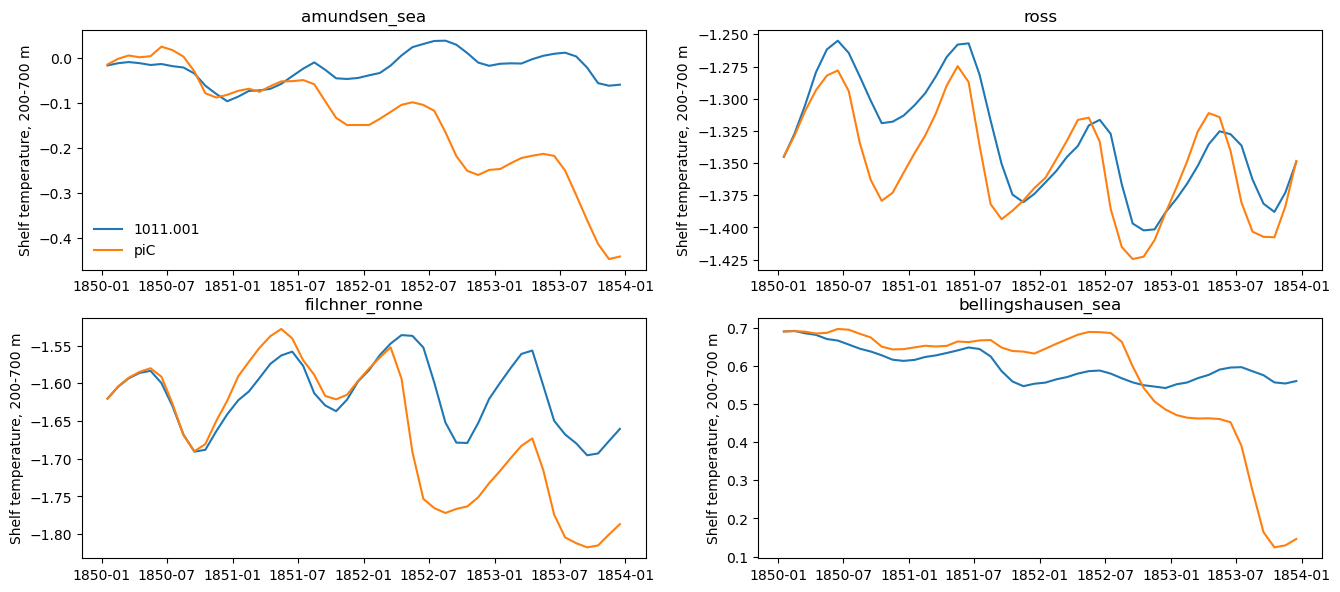

In [5]:
fig, ax = plt.subplots(2,2, figsize=(16,7), dpi=100)

for a, axis in enumerate(ax.ravel()):
    axis.set_ylabel('Shelf temperature, 200-700 m')
    axis.set_title(regions[a])

    varname = f'{regions[a]}_shelf_temp_btw_200_700m'
    axis.plot(ens1011['time_counter'], ens1011[varname], label='1011.001')
    axis.plot(piC['time_counter']    , piC[varname], label='piC')

ax[0,0].legend(frameon=False)

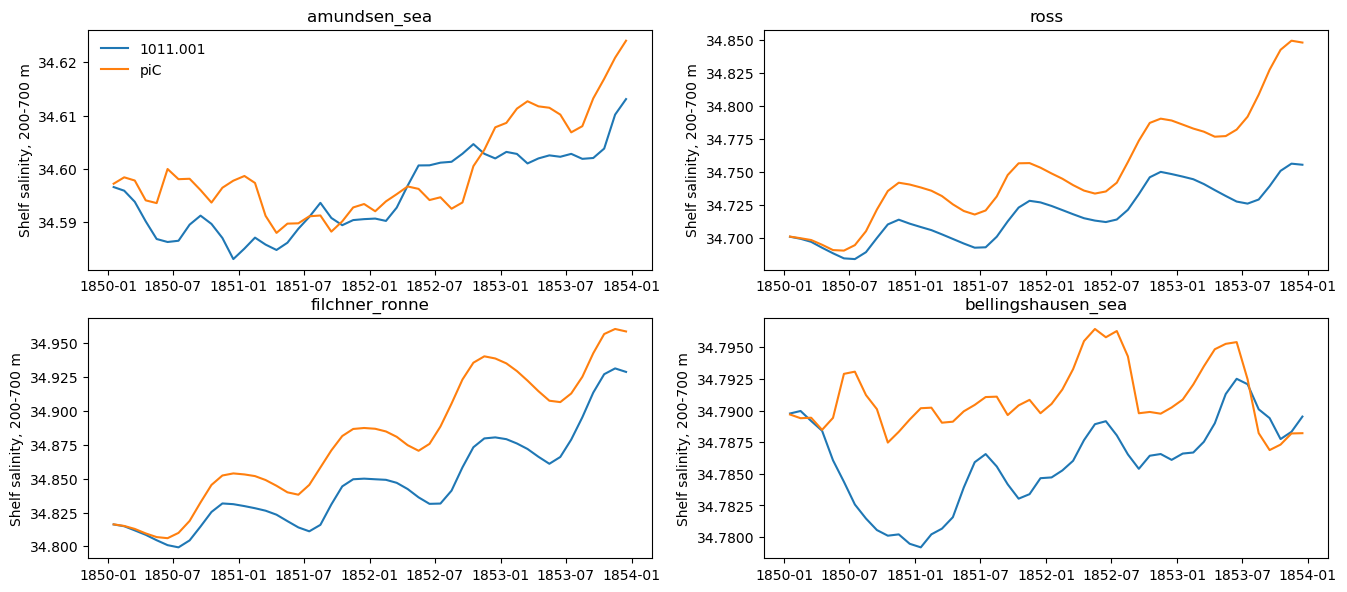

In [6]:
fig, ax = plt.subplots(2,2, figsize=(16,7), dpi=100)

for a, axis in enumerate(ax.ravel()):
    axis.set_ylabel('Shelf salinity, 200-700 m')
    axis.set_title(regions[a])

    varname = f'{regions[a]}_shelf_salt_btw_200_700m'
    axis.plot(ens1011['time_counter'], ens1011[varname], label='1011.001')
    axis.plot(piC['time_counter']    , piC[varname], label='piC')


ax[0,0].legend(frameon=False)

### Ice shelf basal melt rates

Probably can also be identified by timeseries functions

### Sea ice area

Overall and separated by region

In [45]:
ens1011_ice = xr.open_mfdataset(f'{ens1011_dir}files/*ice*')
piC_ice     = xr.open_mfdataset(f'{piC_dir}files/*ice*')

Text(0, 0.5, 'Sea ice area (km2)')

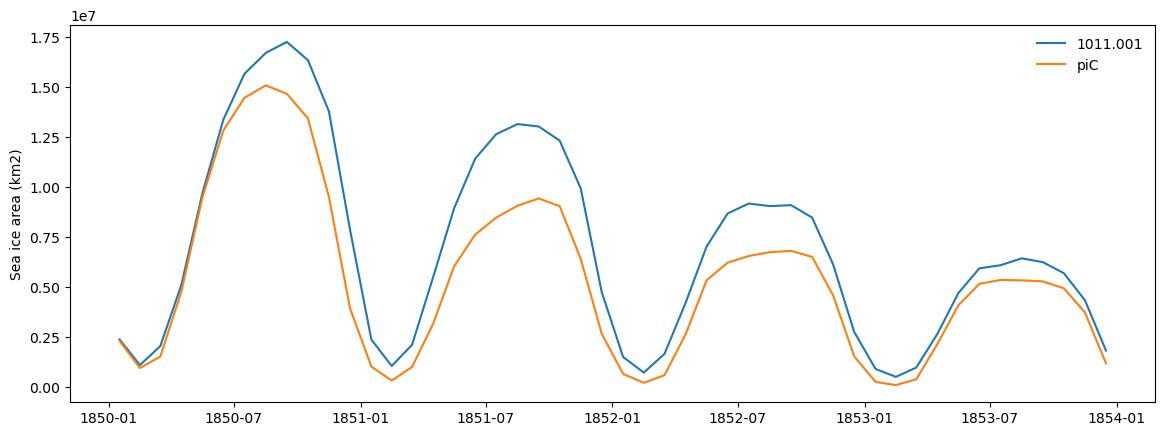

In [47]:
fig, ax = plt.subplots(1,1, figsize=(14,5), dpi=100)
ax.plot(ens1011_ice.time_counter, (ens1011_ice.siconc*ens1011_ice.area).sum(dim=['x','y'])*1e-6, label='1011.001')
ax.plot(piC_ice.time_counter, (piC_ice.siconc*piC_ice.area).sum(dim=['x','y'])*1e-6, label='piC') 
ax.legend(frameon=False)
ax.set_ylabel('Sea ice area (km2)')

### Amundsen undercurrent strength

Quantify as in Haigh et al. 2024
```
The eastward undercurrent is defined using an approach similar to Silvano et al. (2022). We start by locating the 1,000 m isobath at the shelf break between 125° and 108°W, the undercurrent longitudes of interest. For each longitude along the isobath, the along-slope flow beneath the 1,028 kg m−3 isopycnal and above 800 m depth is averaged over a meridional range of three grid points either side of the isobath. The undercurrent speed is then defined as the maximum of these meridionally averaged values at any depth, which typically occurs near 500 m depth. All quantities are then averaged along the undercurrent pathway, with the Dotson-Getz and Pine Island-Thwaites West troughs excluded from the computations. Using alternate undercurrent definitions does not affect our conclusions.
```
Steps
- identify 1000 m isobath between 125-108 W
- at each longitude, average the along-slope flow beneath 1028 kg/m3 isopycnal and above 800 m depth
- undercurrent speed = max of these average values
- undercurrent speed is average along the undercurrent path, excluding the Dotson-Getz, PI-Thwaites troughs

In [3]:
import gsw

In [6]:
# calculate along-slope current speed
fU = xr.open_dataset(f'{ens1011_dir}files/eANT025.L121_1m_18500101_18501231_grid_U.nc').isel(time_counter=slice(0,5))
fT = xr.open_dataset(f'{ens1011_dir}files/eANT025.L121_1m_18500101_18501231_grid_T.nc').isel(time_counter=slice(0,5))
fV = xr.open_dataset(f'{ens1011_dir}files/eANT025.L121_1m_18500101_18501231_grid_V.nc').isel(time_counter=slice(0,5))

nemo_domcfg = xr.open_dataset('/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/bathymetry/domain_cfg-20240305.nc').isel(time_counter=0)

get the direction of the current from the angle between the U and V vectors (first will need to convert to meridional and latitudinal velocities instead of along the grid directions):

$ U^2 = u^2 + v^2$

$\theta = \tan^{-1}(\frac{v}{u})$

I mainly want the direction of u, but also somewhat of v

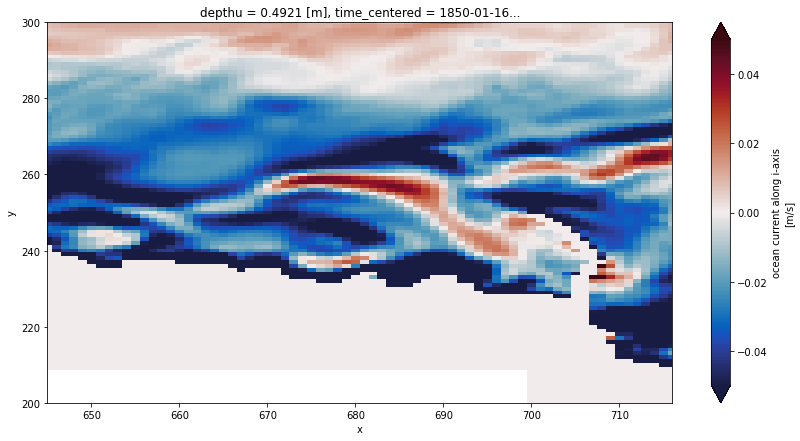

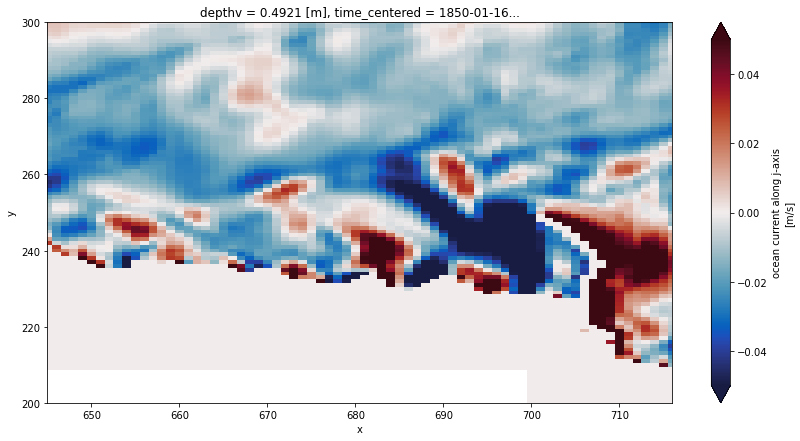

In [42]:
fU.uo.isel(time_counter=0, depthu=0).plot(figsize=(14,7), vmin=-0.05, vmax=0.05, cmap=cmocean.cm.balance, xlim=(645,716), ylim=(200,300))
fV.vo.isel(time_counter=0, depthv=0).plot(figsize=(14,7), vmin=-0.05, vmax=0.05, cmap=cmocean.cm.balance, xlim=(645,716), ylim=(200,300))

In [14]:
theta = np.arctan2(fV.vo.isel(time_counter=0, x=slice(645,716),
                              y=slice(200,300)).rename({'depthv':'depthu'}),fU.uo.isel(time_counter=0, x=slice(645,716),y=slice(200,300)))

In [ ]:
# calculate density:
density = gsw.density.sigma0(fT.so, fT.thetao)
fU = fU.assign({'density':density.rename({'deptht':'depthu', 'y_grid_T':'y', 'x_grid_T':'x'})})

In [8]:
fU_vel = xr.where((fU.nav_lon > -125)*(fU.nav_lon < -108)*(fU.nav_lat > -73.2)*(fU.nav_lat < -71), fU.uo, np.nan)
fU_vel = xr.where((nemo_domcfg.bathy_metry > 800)*(nemo_domcfg.bathy_metry < 1200), fU_vel, np.nan)

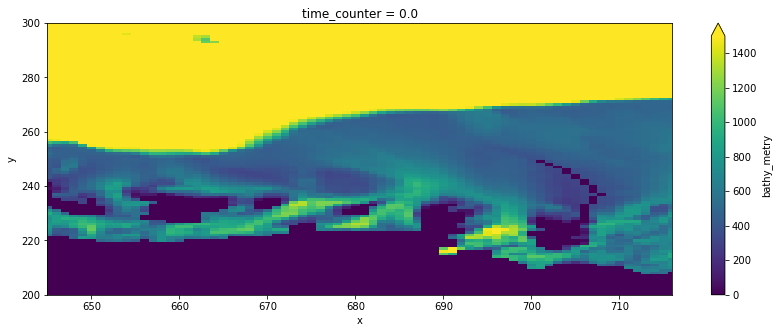

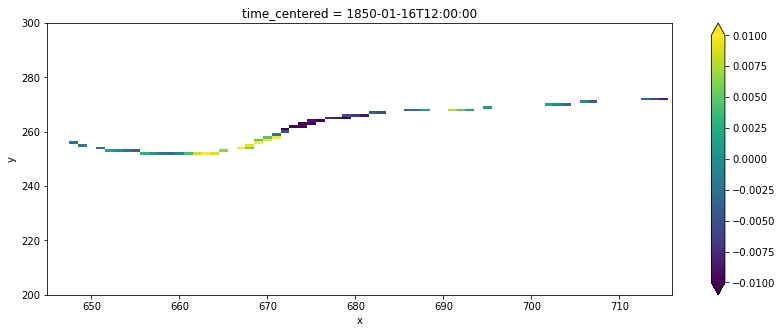

In [100]:
nemo_domcfg.bathy_metry.plot(figsize=(14,5), ylim=(200,300), xlim=(645,716), vmin=0, vmax=1500)
fU_vel.mean(dim='depthu').plot(figsize=(14,5), xlim=(645, 716), ylim=(200, 300), vmin=-0.01, vmax=0.01)

In [9]:
# Step 2 and 3
fU_vel = xr.where((fU_vel.depthu < 800), fU_vel, np.nan)
fU_vel = xr.where((fU.density > 27.8), fU_vel, np.nan)
Uvel = fU_vel.mean(dim='y').max(dim='depthu')
undercurrent_speed = Uvel.mean(dim='x')

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(14,5))
ax.set_ylabel('Undercurrent speed (m/s)')

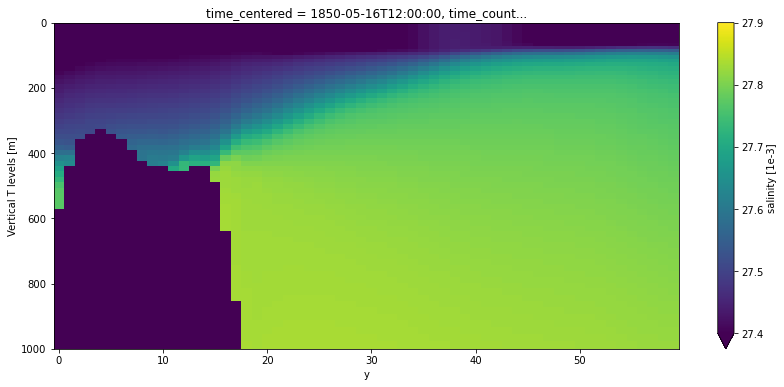

In [55]:
fU.density.isel(time_counter=4, x=670, y=slice(240,300)).plot(figsize=(14,6), ylim=(1000, 0), vmin=27.4, vmax=27.9)

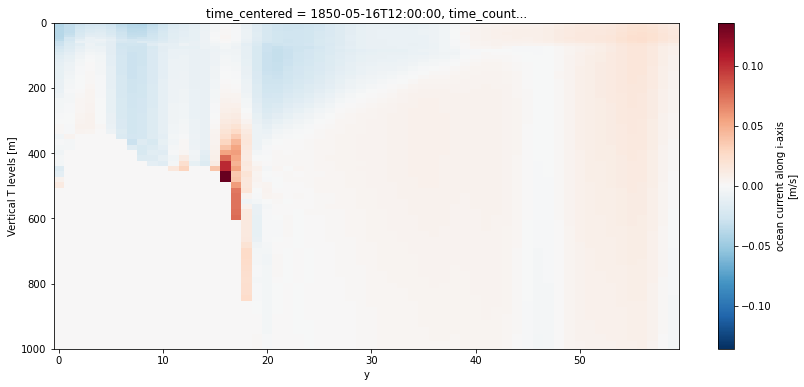

In [51]:
fU.uo.isel(time_counter=4, x=670, y=slice(240,300)).plot(figsize=(14,6), ylim=(1000, 0))

In [138]:
fU.density.max()

<xarray.DataArray 'density' ()>
array(28.13194019)
Coordinates:
    time_centered  datetime64[ns] 1850-01-16T12:00:00
    time_counter   datetime64[ns] 1850-01-16T12:00:00